# LIBRARIES

In [1]:
import csv
import os
import mysql.connector
import subprocess
from datetime import datetime
from langchain import LLMChain
from langchain.chains import LLMChain, LLMMathChain, SequentialChain, TransformChain
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.pydantic_v1 import BaseModel, Field, validator
from langchain.tools import Tool
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import OpenAI, ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_tools_agent, create_openai_functions_agent
from langchain_community.agent_toolkits.sql.prompt import SQL_FUNCTIONS_SUFFIX
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain import hub
from langchain_experimental.tools import PythonREPLTool
from langchain import PromptTemplate
from src.constants import USER, PASSWORD, OPENAI_API_KEY, LLM_MODEL_NAME, HOST, DATABASE, PORT

/Users/priyachoudhari/testproject/env/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


# SETUP SQL CONNECTION

In [2]:
mydb = mysql.connector.connect(
    host=HOST,
    user=USER,
    passwd=PASSWORD
)
mycursor = mydb.cursor()

mycursor.execute(f"CREATE DATABASE IF NOT EXISTS {DATABASE}")

mydb = mysql.connector.connect(
    host=HOST,
    user=USER,
    passwd=PASSWORD,
    database=DATABASE
)
mycursor = mydb.cursor()

# CREATE ALL TABLES

In [3]:
mycursor.execute("CREATE TABLE IF NOT EXISTS distribution_centers(id INT, name VARCHAR(255), latitude FLOAT, longitude FLOAT)")
mycursor.execute("CREATE TABLE IF NOT EXISTS events(id INT, user_id INT, sequence_number INT, session_id VARCHAR(255), created_at TIMESTAMP, ip_address VARCHAR(255), city VARCHAR(255), state VARCHAR(255), postal_code VARCHAR(255), browser VARCHAR(255), traffic_source VARCHAR(255), uri VARCHAR(255), event_type VARCHAR(255))")
mycursor.execute("CREATE TABLE IF NOT EXISTS inventory_items(id INT, product_id INT, created_at TIMESTAMP, sold_at TIMESTAMP, cost FLOAT, product_category VARCHAR(255), product_name VARCHAR(255), product_brand VARCHAR(255), product_retail_price FLOAT, product_department VARCHAR(255), product_sku VARCHAR(255), product_distribution_center_id INT)")
mycursor.execute("CREATE TABLE IF NOT EXISTS order_items(id INT, order_id INT, user_id INT, product_id INT, inventory_item_id INT, status VARCHAR(255), created_at TIMESTAMP, shipped_at TIMESTAMP, delivered_at TIMESTAMP, returned_at TIMESTAMP, sale_price FLOAT)")
mycursor.execute("CREATE TABLE IF NOT EXISTS orders(order_id INT, user_id INT, status VARCHAR(255), gender VARCHAR(255), created_at TIMESTAMP, returned_at TIMESTAMP, shipped_at TIMESTAMP, delivered_at TIMESTAMP, num_of_item INT)")
mycursor.execute("CREATE TABLE IF NOT EXISTS products(id INT, cost FLOAT, category VARCHAR(255), name VARCHAR(255), brand VARCHAR(255), retail_price FLOAT, department VARCHAR(255), sku VARCHAR(255), distribution_center_id INT)")
mycursor.execute("CREATE TABLE IF NOT EXISTS users(id INT, first_name VARCHAR(255), last_name VARCHAR(255), email VARCHAR(255), age INT, gender VARCHAR(255), state VARCHAR(255), street_address VARCHAR(255), postal_code VARCHAR(255), city VARCHAR(255), country VARCHAR(255), latitude FLOAT, longitude FLOAT, traffic_source VARCHAR(255), created_at TIMESTAMP)")

# DATA EXPORT TO MYSQL TABLES

In [4]:
mydb = mysql.connector.connect(
    host=HOST,
    user=USER,
    passwd=PASSWORD,
    database=DATABASE
)
mycursor = mydb.cursor()

table_names = ["distribution_centers", "events", "inventory_items", "order_items", "orders", "products", "users"]

# Function to detect timestamp columns based on data types
def detect_timestamp_columns(cursor, table_name):
    cursor.execute(f"DESCRIBE {table_name}")
    columns = cursor.fetchall()
    timestamp_indices = [i for i, column in enumerate(columns) if column[1].startswith('timestamp')]
    return timestamp_indices

for table_name in table_names:
    timestamp_indices = detect_timestamp_columns(mycursor, table_name)

    with open(f"data/{table_name}.csv", 'r', encoding='utf-8') as csv_file:  # Specifying utf-8 encoding
        csv_data = csv.reader(csv_file)
        next(csv_data)  # Skip headers
        counter = 0
        print(f"Currently inserting data into table {table_name}")

        for row in csv_data:
            if counter % 10000 == 0:
                print(f"Progress is {counter}")

            row = [None if cell == "" else cell for cell in row]

            # Correct datetime values if necessary
            for col_index in timestamp_indices:
                if row[col_index] is not None and row[col_index] != '':
                    try:
                        datetime.strptime(row[col_index], '%Y-%m-%d %H:%M:%S')
                    except ValueError:
                        # Handle invalid datetime value by setting it to None
                        row[col_index] = None
                else:
                    # Handle None or empty string
                    row[col_index] = None

            postfix = ','.join(["%s"] * len(row))
            query = f"INSERT INTO {table_name} VALUES ({postfix})"
            try:
                mycursor.execute(query, row)
            except mysql.connector.Error as err:
                print(f"Error: {err}")
                print(f"Failed row: {row}")

            counter += 1

        mydb.commit()
        print(f"Completed inserting data into table {table_name}")

Currently inserting data into table distribution_centers
Progress is 0
Completed inserting data into table distribution_centers
Currently inserting data into table events
Progress is 0
Progress is 10000
Progress is 20000
Progress is 30000
Progress is 40000
Progress is 50000
Progress is 60000
Progress is 70000
Progress is 80000
Progress is 90000
Progress is 100000
Progress is 110000
Progress is 120000
Progress is 130000
Progress is 140000
Progress is 150000
Progress is 160000
Progress is 170000
Progress is 180000
Progress is 190000
Progress is 200000
Progress is 210000
Progress is 220000
Progress is 230000
Progress is 240000
Progress is 250000
Progress is 260000
Progress is 270000
Progress is 280000
Progress is 290000
Progress is 300000
Progress is 310000
Progress is 320000
Progress is 330000
Progress is 340000
Progress is 350000
Progress is 360000
Progress is 370000
Progress is 380000
Progress is 390000
Progress is 400000
Progress is 410000
Progress is 420000
Progress is 430000
Progres

# SQL TABLE CONNECTION

In [5]:
import urllib.parse
PASSWORD = urllib.parse.quote_plus(PASSWORD)

In [8]:
sql_db = SQLDatabase.from_uri(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

In [ ]:
#sql_db = SQLDatabase.from_uri(f"mssql+pyodbc://{USER}:{PASSWORD}@{HOST}:{PORT}/?driver=ODBC+Driver+17+for+SQL+Server")

InterfaceError: (pyodbc.InterfaceError) ('IM002', '[IM002] [unixODBC][Driver Manager]Data source name not found and no default driver specified (0) (SQLDriverConnect)')
(Background on this error at: https://sqlalche.me/e/20/rvf5)

In [9]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
model_name = LLM_MODEL_NAME

In [10]:
llm = OpenAI(temperature=0.0)

# SQL QUERY ENGINE

- Creates SQL query from the user input

In [11]:
class SQLQueryEngine:
    """
    A class representing an SQL query engine.

    Attributes:
        llm (ChatOpenAI): An instance of ChatOpenAI used for natural language processing.
        toolkit (SQLDatabaseToolkit): An SQL database toolkit instance.
        context (dict): Contextual information obtained from the SQL database toolkit.
        tools (list): List of tools available for SQL query execution.
        prompt (ChatPromptTemplate): The prompt used for interactions with the SQL query engine.
        agent_executor (AgentExecutor): An executor for the SQL query engine's agent.
    """
    def __init__(self, model_name, db):
        self.llm = ChatOpenAI(model=model_name, temperature=0)
        self.toolkit = SQLDatabaseToolkit(db=db, llm=self.llm)
        self.context = self.toolkit.get_context()
        self.tools = self.toolkit.get_tools()
        self.prompt = None
        self.agent_executor = None

    def set_prompt(self):
        messages = [
            HumanMessagePromptTemplate.from_template("{input}"),
            AIMessage(content=SQL_FUNCTIONS_SUFFIX),
            MessagesPlaceholder(variable_name="agent_scratchpad")
            ]
        self.prompt = ChatPromptTemplate.from_messages(messages)
        self.prompt = self.prompt.partial(**self.context)

    def initialize_agent(self):
        agent = create_openai_tools_agent(self.llm, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(
            agent=agent,
            tools=self.toolkit.get_tools(),
            verbose=True,
        )

    def get_query_data(self, query):
        if 'return' in query:
            query = query + "\n" + "return percentage is defined as total number of returns divided by total number of orders. You can join orders table with users table to know more about each user"
        return self.agent_executor.invoke({"input": query})['output']

# PYTHON DASHBOARD ENGINE

- Creates Streamlit dashboard from data output by SQLQueryEngine

In [12]:
# REPL -> Read Evaluate Print Loop
class PythonDashboardEngine:
    """
    A class representing a Python dashboard engine.

    Attributes:
        tools (list): A list of tools available for the dashboard engine.
        instructions (str): Instructions guiding the behavior of the dashboard engine.
        prompt (str): The prompt used for interactions with the dashboard engine.
        agent_executor (AgentExecutor): An executor for the dashboard engine's agent.
    """
    def __init__(self):
        self.tools = [PythonREPLTool()]
        self.instructions = """You are an agent designed to write a python code to answer questions.
        You have access to a python REPL, which you can use to execute python code.
        If you get an error, debug your code and try again.
        You might know the answer without running any code, but you should still run the code to get the answer.
        If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
        Always output the python code only.
        """
        base_prompt = hub.pull("langchain-ai/openai-functions-template")
        self.prompt = base_prompt.partial(instructions=self.instructions)
        self.agent_executor = None

    def initialize(self):
        agent = create_openai_functions_agent(ChatOpenAI(model=model_name, temperature=0), self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)

    def get_output(self, query):
        output = self.agent_executor.invoke({"input": "Write a code in python to plot the following data\n\n" + query})
        return output['output']

    def parse_output(self, inp):
        inp = inp.split('```')[1].replace("```", "").replace("python", "").replace("plt.show()", "")
        outp = "import streamlit as st\nst.set_option('deprecation.showPyplotGlobalUse', False)\nst.title('E-commerce Company Insights')\nst.write('Here is our LLM generated dashboard')" \
                + inp + "st.pyplot()\n"
        return outp

    def export_to_streamlit(self, data):
        with open("app.py", "w") as text_file:
            text_file.write(self.parse_output(data))

        command = "streamlit run app.py"
        proc = subprocess.Popen([command], shell=True, stdin=None, stdout=None, stderr=None, close_fds=True)

# INITIATE SQL AND DASHBOARD ENGINES

In [13]:
global sql_query_engine, dashboard_engine

def init_engines():
    sql_query_engine = SQLQueryEngine(model_name, sql_db)
    sql_query_engine.set_prompt()
    sql_query_engine.initialize_agent()

    dashboard_engine = PythonDashboardEngine()
    dashboard_engine.initialize()
    return sql_query_engine, dashboard_engine

# EXAMPLE QUERIES

## QUERY 1

- Number of users with their gender

/Users/priyachoudhari/testproject/env/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'users'}`



CREATE TABLE users (
	id INTEGER, 
	first_name VARCHAR(255), 
	last_name VARCHAR(255), 
	email VARCHAR(255), 
	age INTEGER, 
	gender VARCHAR(255), 
	state VARCHAR(255), 
	street_address VARCHAR(255), 
	postal_code VARCHAR(255), 
	city VARCHAR(255), 
	country VARCHAR(255), 
	latitude FLOAT, 
	longitude FLOAT, 
	traffic_source VARCHAR(255), 
	created_at TIMESTAMP NULL
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from users table:
id	first_name	last_name	email	age	gender	state	street_address	postal_code	city	country	latitude	longitude	traffic_source	created_at
9766	Brandon	Phillips	brandonphillips@example.com	44	M	Acre	717 Martinez Street Apt. 782	69917-400	Rio Branco	Brasil	-9.94557	-67.8356	Search	None
17324	Ryan	Smith	ryansmith@e

Matplotlib is building the font cache; this may take a moment.


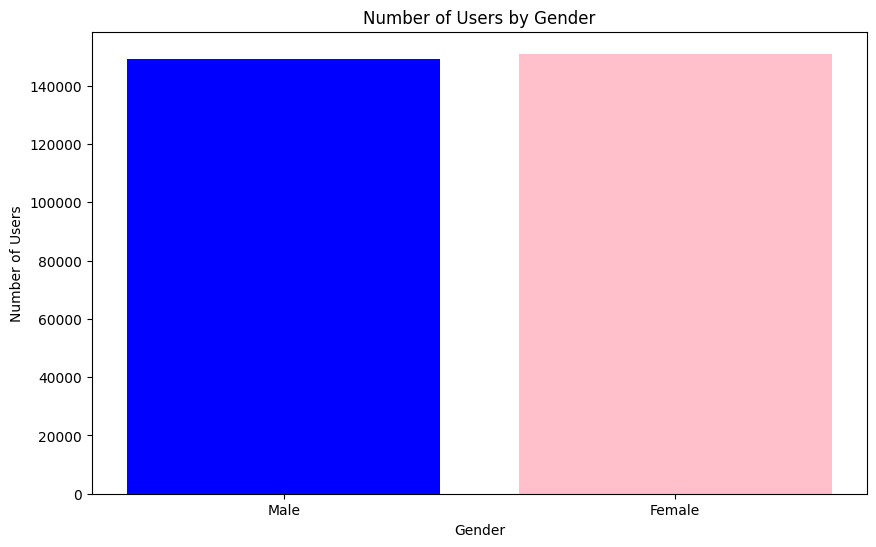

I've created the Python code to plot the number of users by their gender. Here's the code:

```python
import matplotlib.pyplot as plt

# Data
genders = ['Male', 'Female']
user_counts = [149064, 150936]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(genders, user_counts, color=['blue', 'pink'])
plt.title('Number of Users by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.show()
```

This code will generate a bar chart displaying the number of male and female users as specified.

> Finished chain.


/bin/sh: streamlit: command not found


In [15]:
sql_query_engine, dashboard_engine = init_engines()
query = "Number of users with their gender"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)

## QUERY 2

- number of users in each country who came via facebook

In [16]:
#sql_query_engine, dashboard_engine = init_engines()
query = "number of users in each country who came via facebook"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'users,events'}`



CREATE TABLE events (
	id INTEGER, 
	user_id INTEGER, 
	sequence_number INTEGER, 
	session_id VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	ip_address VARCHAR(255), 
	city VARCHAR(255), 
	state VARCHAR(255), 
	postal_code VARCHAR(255), 
	browser VARCHAR(255), 
	traffic_source VARCHAR(255), 
	uri VARCHAR(255), 
	event_type VARCHAR(255)
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from events table:
id	user_id	sequence_number	session_id	created_at	ip_address	city	state	postal_code	browser	traffic_source	uri	event_type
1679667	None	3	ac0caa7c-cb18-4be3-9843-6e19b39e298b	None	33.194.53.72	São Paulo	São Paulo	02675-031	Firefox	Adwords	/cancel	cancel
1405655	None	3	eacfccad-fbe4-4326-b775-2b8d8c30e114	None	46.34.135.113	São Paulo

/bin/sh: streamlit: command not found


## QUERY 3

- number of orders per month since January 2020

In [17]:
#sql_query_engine, dashboard_engine = init_engines()
query = "number of orders per month since January 2020"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'orders'}`



CREATE TABLE orders (
	order_id INTEGER, 
	user_id INTEGER, 
	status VARCHAR(255), 
	gender VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	returned_at TIMESTAMP NULL, 
	shipped_at TIMESTAMP NULL, 
	delivered_at TIMESTAMP NULL, 
	num_of_item INTEGER
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from orders table:
order_id	user_id	status	gender	created_at	returned_at	shipped_at	delivered_at	num_of_item
23	15	Cancelled	F	None	None	None	None	1
45	30	Cancelled	F	None	None	None	None	1
60	40	Cancelled	F	None	None	None	None	4
*/
Invoking: `sql_db_query` with `{'query': "SELECT YEAR(created_at) AS year, MONTH(created_at) AS month, COUNT(*) AS number_of_orders FROM orders WHERE created_at >= '2020-01-01' GROUP BY YEAR(created_at), MONTH(crea

## QUERY 4

- top 3 product categories with highest number of returns by count

In [18]:
#sql_query_engine, dashboard_engine = init_engines()
query = "top 3 product categories with highest number of returns by count"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'orders'}`



CREATE TABLE orders (
	order_id INTEGER, 
	user_id INTEGER, 
	status VARCHAR(255), 
	gender VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	returned_at TIMESTAMP NULL, 
	shipped_at TIMESTAMP NULL, 
	delivered_at TIMESTAMP NULL, 
	num_of_item INTEGER
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from orders table:
order_id	user_id	status	gender	created_at	returned_at	shipped_at	delivered_at	num_of_item
23	15	Cancelled	F	None	None	None	None	1
45	30	Cancelled	F	None	None	None	None	1
60	40	Cancelled	F	None	None	None	None	4
*/
Invoking: `sql_db_schema` with `{'table_names': 'order_items'}`



CREATE TABLE order_items (
	id INTEGER, 
	order_id INTEGER, 
	user_id INTEGER, 
	product_id INTEGER, 
	inventory_item_id INTEGER, 
	status VARCHAR(

/bin/sh: streamlit: command not found


## QUERY 5

- return percentage country wise

In [19]:
#sql_query_engine, dashboard_engine = init_engines()
query = "return percentage country wise"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'orders,users'}`



CREATE TABLE orders (
	order_id INTEGER, 
	user_id INTEGER, 
	status VARCHAR(255), 
	gender VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	returned_at TIMESTAMP NULL, 
	shipped_at TIMESTAMP NULL, 
	delivered_at TIMESTAMP NULL, 
	num_of_item INTEGER
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from orders table:
order_id	user_id	status	gender	created_at	returned_at	shipped_at	delivered_at	num_of_item
23	15	Cancelled	F	None	None	None	None	1
45	30	Cancelled	F	None	None	None	None	1
60	40	Cancelled	F	None	None	None	None	4
*/


CREATE TABLE users (
	id INTEGER, 
	first_name VARCHAR(255), 
	last_name VARCHAR(255), 
	email VARCHAR(255), 
	age INTEGER, 
	gender VARCHAR(255), 
	state VARCHAR(255), 
	street_address VARCHAR(255), 
	post

/bin/sh: streamlit: command not found


## QUERY 6

- which are my top 5 geographies with highest business



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'orders'}`



CREATE TABLE orders (
	order_id INTEGER, 
	user_id INTEGER, 
	status VARCHAR(255), 
	gender VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	returned_at TIMESTAMP NULL, 
	shipped_at TIMESTAMP NULL, 
	delivered_at TIMESTAMP NULL, 
	num_of_item INTEGER
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from orders table:
order_id	user_id	status	gender	created_at	returned_at	shipped_at	delivered_at	num_of_item
23	15	Cancelled	F	None	None	None	None	1
45	30	Cancelled	F	None	None	None	None	1
60	40	Cancelled	F	None	None	None	None	4
*/
Invoking: `sql_db_schema` with `{'table_names': 'users'}`



CREATE TABLE users (
	id INTEGER, 
	first_name VARCHAR(255), 
	last_name VARCHAR(255), 
	email VARCHAR(255), 
	age INTEGER, 
	gender VARCHAR(255), 
	stat

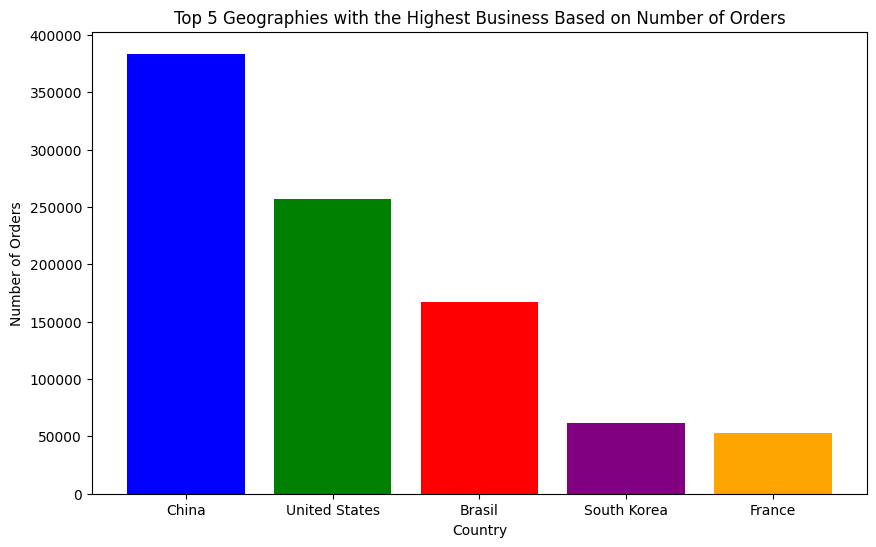


Invoking: `Python_REPL` with `{'query': "import matplotlib.pyplot as plt\n\n# Data\ncountries = ['China', 'United States', 'Brasil', 'South Korea', 'France']\norders = [383562, 257310, 167292, 61308, 52704]\n\n# Plotting\nplt.figure(figsize=(10, 6))\nplt.bar(countries, orders, color=['blue', 'green', 'red', 'purple', 'orange'])\nplt.title('Top 5 Geographies with the Highest Business Based on Number of Orders')\nplt.xlabel('Country')\nplt.ylabel('Number of Orders')\nplt.show()"}`


Here is the Python code to plot the data for the top 5 geographies with the highest business based on the number of orders:

```python
import matplotlib.pyplot as plt

# Data
countries = ['China', 'United States', 'Brasil', 'South Korea', 'France']
orders = [383562, 257310, 167292, 61308, 52704]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(countries, orders, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Top 5 Geographies with the Highest Business Based on Number of Orders')
plt.xlabel('Co

/bin/sh: streamlit: command not found


In [20]:
#sql_query_engine, dashboard_engine = init_engines()
query = "which are my top 5 geographies with highest business"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)

## QUERY 7

- which product categories have the highest margins in 2024



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


distribution_centers, events, inventory_items, order_items, orders, products, users
Invoking: `sql_db_schema` with `{'table_names': 'products,order_items'}`



CREATE TABLE order_items (
	id INTEGER, 
	order_id INTEGER, 
	user_id INTEGER, 
	product_id INTEGER, 
	inventory_item_id INTEGER, 
	status VARCHAR(255), 
	created_at TIMESTAMP NULL, 
	shipped_at TIMESTAMP NULL, 
	delivered_at TIMESTAMP NULL, 
	returned_at TIMESTAMP NULL, 
	sale_price FLOAT
)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci

/*
3 rows from order_items table:
id	order_id	user_id	product_id	inventory_item_id	status	created_at	shipped_at	delivered_at	returned_at	sale_price
162569	112164	89224	14235	438986	Cancelled	None	None	None	None	0.02
25143	17365	13804	14235	67816	Complete	None	None	None	None	0.02
162494	112111	89185	14235	438784	Complete	None	None	None	None	0.02
*/


CREATE TABLE products (
	id INTEGER, 
	cost FL

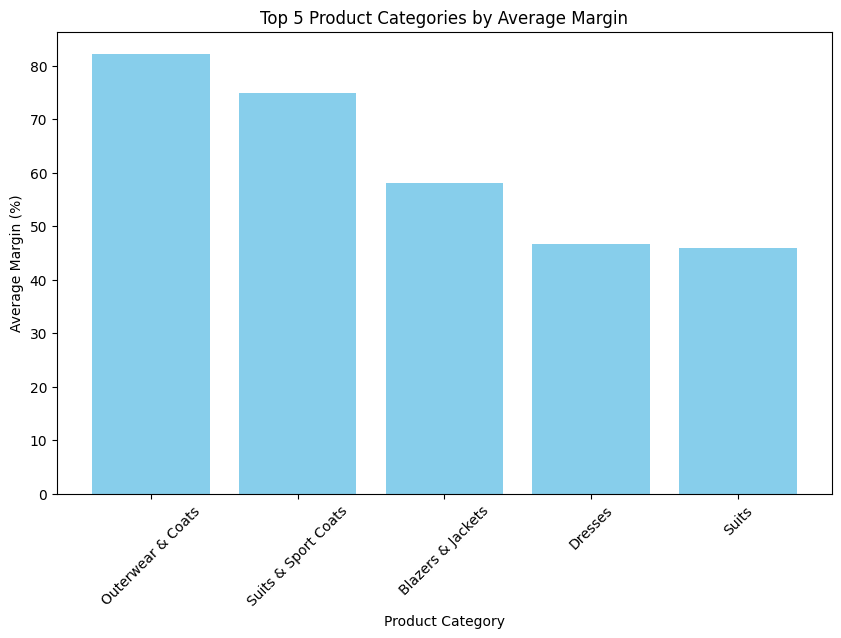


Invoking: `Python_REPL` with `{'query': "import matplotlib.pyplot as plt\n\n# Data\ncategories = ['Outerwear & Coats', 'Suits & Sport Coats', 'Blazers & Jackets', 'Dresses', 'Suits']\nmargins = [82.25, 74.90, 58.03, 46.60, 45.94]\n\n# Plotting\nplt.figure(figsize=(10, 6))\nplt.bar(categories, margins, color='skyblue')\nplt.title('Top 5 Product Categories by Average Margin')\nplt.xlabel('Product Category')\nplt.ylabel('Average Margin (%)')\nplt.xticks(rotation=45)\nplt.show()"}`


The code to plot the given data is as follows:

```python
import matplotlib.pyplot as plt

# Data
categories = ['Outerwear & Coats', 'Suits & Sport Coats', 'Blazers & Jackets', 'Dresses', 'Suits']
margins = [82.25, 74.90, 58.03, 46.60, 45.94]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, margins, color='skyblue')
plt.title('Top 5 Product Categories by Average Margin')
plt.xlabel('Product Category')
plt.ylabel('Average Margin (%)')
plt.xticks(rotation=45)
plt.show()
```

This code will generate a

/bin/sh: streamlit: command not found


In [21]:
#sql_query_engine, dashboard_engine = init_engines()
query = "which product categories have the highest margins in 2024"
sql_query_engine_output = sql_query_engine.get_query_data(query)
#print(sql_query_engine_output)

dashboard_engine_output = dashboard_engine.get_output(sql_query_engine_output)
dashboard_engine.export_to_streamlit(dashboard_engine_output)